In [2]:
%matplotlib inline
%precision 16
import numpy
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint, solve_ivp
from pylab import *
import timeit

One popular ODE model for tumor growth is based on the logistic equations. Rather than just modelling tumor growth as a logistic function, it introduces the interaction between tumor and normal cells as a factor influencing growth rates, as supported by cellular tumor research. However, a newer model proposes the introduction of another factor: a simple immune system. To explore this model further, I will: 

(1) (a) implement a version of a logistic ODE model for tumor-normal-immune interactions, as laid out by Feizabadi et al [1] (b) explore a few test cases, observe model behavior

(2) explore the effects of different styles of ODE solvers: "hybrid", implicit, and explicit

(3) with the most computationally efficient solver, explore model kinetics with regard to how drug dosing changes tumor/normal cell behavior

(4) Investigate how drug resistance can be added into this system

With all this, I hope to improve my understanding of (a) ODE models for tumor growth, (b) immune system-tumor cell-normal cell interaction, (c) the effects of the design choices made in this model on its output

Reference:

[1] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3107489/

## Problem Justification [10 pts] 

Briefly describe why this problem is important to you,  and, if possible, to anyone else.

Mathematical models (particularly ODE models) can be a useful way to understand cancer tumor growth and development and particularly to make predictions about the efficacy of cancer treatments (1). It's certainly worthwhile to take a closer look at how those models are constructed, especially if they have real-world consequences on what drugs might make it to FDA screenings and so on.

Beyond that, selecting a solver for the model can have real effects on the reliability/error when running an ODE model (2) with regard to computation speed and accuracy, so it's a worthwhile task to investigate a few types of solvers to see what might suit this particular model. 

I personally am interested to explore parameters studies on this model as a way to better understand the design of the model with regard to how the parameters influence each other/interact. 

Last but not least, I take a look at a potential way of incorporating drug resistance for chemotherapy into the model. This is a real and particularly painful challenge in cancer treatment. I specifically look at physiological/mutation-based chemotherapy resistance to observe how it changes tumor and normal cell populations over time. Part of what makes resistance hard to combat is how unknown its mechanisms really are, so this is just one other way to think about a much large (and more complicated) problem.  

References:

(1) https://bmccancer.biomedcentral.com/track/pdf/10.1186/s12885-016-2164-x.pdf

(2) https://www.nature.com/articles/s41598-021-82196-2.pdf

## Numerical Methods: Methods Used + Implementations

Part 1) Implement base and enhanced model on a few basic situations, compare:
I'll use scipy.integrate's solve_ivp with LSODA to integrate/solve the base and enhanced ODE models. I go into why I select LSODA in part 2, but it's by far the most efficient in this case. When implementing the models, I will use numpy testing to make sure that the initial conditions get returned as expected to verify the derivative calculator functions I'm passing in to scipy,integrate's functions. 

I will also graph the evolution of tumor cell populations over time in the base and enhanced models, to get a sense for how the chemotherapy/immunotherapy interactions introduced here affect tumor cell populations.

Part 2) Compare different solver methods for our model:
scipy BDF, RK45, scipy LSODA (as authors did in (1) to analyze tons of other ODE models). These are all parts of scipy.integrate. 
Here, I'll use numpy.testing to attempt see how close they are to one another, and the time module to calculate computation times. 

Part 3) Exploring Model Kinetics:
Vary parameters (using numpy.linspace and the solver selected above), graph the outputs. Again, using odeint with LSODA, since the goal here is to observe model behaviour in various scenarios and the efficiency of odeint lets us run hundreds of iterations of the ODE system. 

Part 4) Introducing drug resistance:
Same as part 1, I use solve_ivp with LSODA!

## Implementation

## Part 1: Implementing the base logistic tumor cell-normal cell model, then adding the immune system interactions (with graphing!)
### Base Model: 

At a basic level, we can look at tumor cell-normal cell interactions in a logistic model with the ODE System of 2 equations as follows: 

$$\frac{dT}{dt} = r_T T\left(1-\frac{T}{K_T}\right)- \beta \left(\frac{\rho_0N}{\rho_1+N} \right)$$
$$\frac{dN}{dt} = r_N T\left(1-\frac{N}{K_N}\right)- \kappa T \left(1-\frac{T}{T^*} \right)$$

The first term of each equation represents the logistic growth pattern of both tumor and normal cells, which is dependent on both the total number of cells currently available as well the carrying capacity of the system for normal and tumor cells. 

The second term of each equation represents normal cell-tumor cell interactions, which depends on coupling constants & interaction rates btw. tumor and normal cells, and the critical number of tumor cells. 

Parameters/Variables & their Values (for now):

|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>|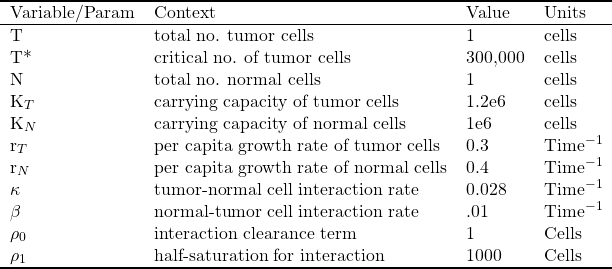

Now, I'll implement the model in a way that could work for solve_ivp or odeint. As the original authors did, I'm implementing the model with initial conditions of 1 tumor and 1 normal cell. 

In [3]:
#####SETTING UP THE FUNCTION TO USE solve_ivp FUNCTIONS FROM SCIPY########
#parameters
T_star = 300000
k_T = 1.2*(10**6)
k_N = 10**6
r_T = 0.3
r_N = 0.4
kappa = 0
beta = 0
rho_0 = 1
rho_1 = 1000

params = [T_star, k_T, k_N, r_T, r_N, kappa, beta, rho_0, rho_1]

#initial condition
T_0 = 1
N_0 = 1
initial_condition = [T_0, N_0]

#time interval
time_0 = 0
time_end = 200
t = (time_0, time_end)
t_2 = numpy.linspace(time_0, time_end, 200)
def base_f(t, initial_condition, params):
    T, N = initial_condition
    T_star, k_T, k_N, r_T, r_N, kappa, beta, rho_0, rho_1 = params
    
    derivs = [r_T*T*(1-T/k_T)-beta*((rho_0*N)/(rho_1+N)),
             r_N*N*(1-N/k_N)+ kappa*T*(1-T/T_star)]
    return derivs

#BaseModel = odeint(base_f, initial_condition, t_2, args=(params,), tfirst=True)
base_model = solve_ivp(base_f, t, initial_condition, args = (params,), rtol=1.e-6, atol=1.e-9, method = 'LSODA')

In order to make sure that the function representing the ODE above is accurate, let's verify that the initial condition comes back as expected.

In [4]:
#######INITIAL CONDITION#######
l = base_f(t, initial_condition, params)
answer = [r_T*1*(1-1/k_T)-beta*((rho_0*1)/(rho_1+1)),
             r_N*1*(1-1/k_N)+ kappa*1*(1-1/T_star)]
numpy.testing.assert_allclose(l, answer)
print('initial condition success!')

initial condition success!


Next, let's graph tumor and normal cell populations. First, without any interaction between tumor/normal cells, then with the amounts listed in the table above for $\beta, \kappa$. This assumes a beta which is much larger than kappa, keeping in line with the reality that tumor-normal interactions are more fatal to tumor cells than normal-tumor interactions are to normal cells. In both cases, we're using initial conditions of 1 tumor and normal cell. 

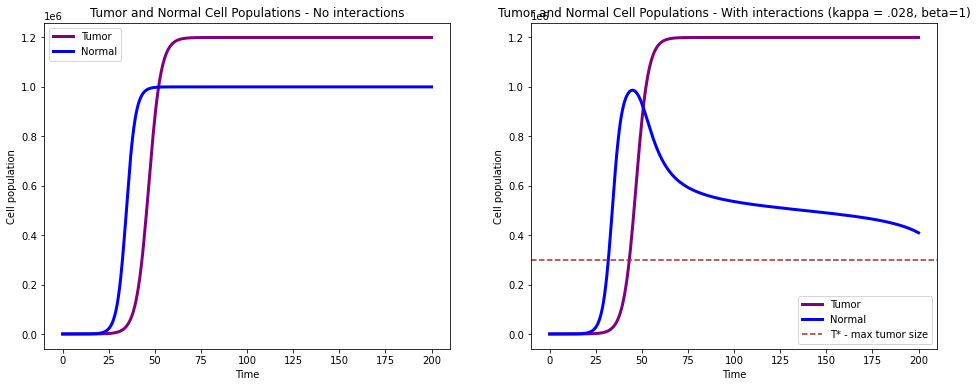

<Figure size 432x288 with 0 Axes>

In [5]:
fig1 = plt.figure(1, figsize=(16,6))
ax1 = fig1.add_subplot(1,2,1)
ax1.plot(base_model.t, base_model.y[0], color='purple', linewidth=3, label ="Tumor")
ax1.plot(base_model.t, base_model.y[1], color='blue', linewidth=3, label ="Normal")
ax1.set_xlabel('Time')
ax1.set_ylabel('Cell population')
ax1.set_title("Tumor and Normal Cell Populations - No interactions")
ax1.legend()

###ADDING NORMAL-TUMOR AND TUMOR-NORMAL INTERACTION####
beta = 1
kappa = 0.028
params = [T_star, k_T, k_N, r_T, r_N, kappa, beta, rho_0, rho_1]
BaseModel_int = solve_ivp(base_f, t, initial_condition,args=(params,), rtol=1.e-6, atol=1.e-9, method='LSODA')

fig2 = plt.figure(2)
ax2 = fig1.add_subplot(1,2,2)
ax2.plot(BaseModel_int.t, BaseModel_int.y[0], color='purple', linewidth=3, label ="Tumor")
ax2.plot(BaseModel_int.t, BaseModel_int.y[1], color='blue', linewidth=3, label ="Normal")
ax2.axhline(y=300000, color = 'brown', linestyle='--', label='T* - max tumor size')
ax2.set_xlabel('Time')
ax2.set_ylabel('Cell population')
ax2.set_title("Tumor and Normal Cell Populations - With interactions (kappa = .028, beta=1)")
ax2.legend()

When both tumor and normal cells are allowed to grow without accounting for any interaction between them, they just grow in a logistic curve. Since we have tumor cells at a higher carrying capacity, they naturally grow to a higher population. 

Also as we would expect to see, when tumor and normal cells are allowed to interact, as soon as tumor cells reach T* (critical number of tumor cells/maximum tumor size), the number of normal cells starts declining rapidly, but tumor cells just keep growing in population. 

### Adding Immune System Interactions: 
There are 4 chief considerations that are being added for introducing interactions with the immune system:

(1) Effector cells- E(t) - Immune system actors, like T cells or other activated immune cells, whose presence is toxic to tumor cells.

(2) IL-2 concentration - I(t) - A cytokine responsible for T cell activation, growth, and differentiation. Basically, more IL-2 means more effector cells that can fight the tumor cells!

(3) Virus concentration - V(t) - Immune-suppression viruses, whose presence reduces the efficiency of effector cells. They can be "defeated" by effector cells. 

(4) Chemo/Immunotherapy - Adding a term $a_\phi\phi$ where $\phi = T, N, E$ (tumor, normal, effective cell populations) allows for drug interaction. Chemotherapeutic agents target tumor cells in a dose-dependent manner but cause a loss to all cells in the area. Immunotherapeutic agents can directly stimulate T cell population growth, in turn reducing tumor cell populations. 

The new system includes three new equations for the three new variables being introduced. 

$$\frac{dT}{dt} = r_T T\left(1-\frac{T}{K_T}\right)- \beta \frac{\rho_0N}{\rho_1+N} - \frac{aET}{g_2 + T} -a_T*T$$
$$\frac{dN}{dt} = r_N T\left(1-\frac{N}{K_N}\right)- \kappa T \left(1-\frac{T}{T^*} \right)-a_N*N$$
$$\frac{dE}{dt} = cT - \mu_2 E + \frac{p_1 EI}{g_1 +I} - \alpha VE - a_E(1-e^{-\xi MC})E - a_{EE}*E$$
$$\frac{dI}{dt} = \frac{p_2 TE}{g_3 + T}-\mu_3I $$
$$\frac{dV}{dt} = \frac{\eta V}{b+ V} - \gamma VE - \mu_1 V$$

Of course with new equations, come new parameters and variables. Here's everything new:

|>>>>>>>>>>>>>>>>>>>>>>>>>>>>|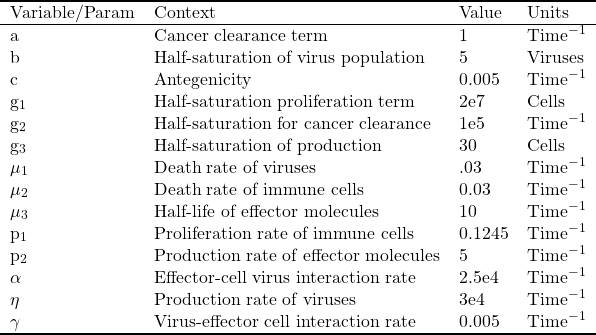

And now to graph populations over time for tumor, normal, and effector cells in a few cases. We're using initial conditions with 1 tumor, normal, and effector cell, 1 virus, and no IL-3. First, we will test to make sure the initial condition comes back as expected. 

In [6]:
#adding new constant parameters
a = 1
b = 5
c = .005
g_1 = 2*(10**7)
g_2= 10**5
g_3=30
u_1=.03
u_2=.03
u_3=10
p_1=.1245
p_2=5
alpha= 2.5*(10**-4)
eta=3*(10**4)
gamma =.005
immune_params = [a,b,c,g_1, g_2, g_3, u_1, u_2, u_3, p_1, p_2, alpha, eta, gamma]
a_T, a_N, a_E, a_EE = [0.05,.01,.01,0]
drug_params = [a_T, a_N, a_E, a_EE]
immune_initial_conditions = [1,1,1,1,1]
def f(t,immune_initial_condition, params, immune_params, drug_params):
    T, N, E, I, V = immune_initial_condition
    T_star, k_T, k_N, r_T, r_N, kappa, beta, rho_0, rho_1 = params
    a,b,c,g_1, g_2, g_3, u_1, u_2, u_3, p_1, p_2, alpha, eta, gamma = immune_params
    a_T, a_N, a_E, a_EE = drug_params
    derivs = [(r_T*T*(1-(T/k_T))-beta*((rho_0*N)/(rho_1+N))- (a*E*T)/(g_2+T)-a_T*T),
             (r_N*N*(1-N/k_N)+kappa*T*(1-T/T_star)-a_N*N),
             (c*T-u_2*E + (p_1*E*I)/(g_1+I)-alpha*V*E-a_E*E +a_EE*E),
             ((p_2*T*E)/(g_3+T)-u_3*I),
             ((eta*V)/(b+V)-gamma*V*E-u_1*V)]
    return derivs
t_long = (0,300)
enhanced_model = odeint(f, immune_initial_conditions, t_2, args = (params,immune_params,drug_params,),tfirst=True)
enh = solve_ivp(f, t_long, immune_initial_conditions, args = (params, immune_params, drug_params), method='LSODA',rtol=1.e-6, atol=1.e-9)
a_T, a_N, a_E, a_EE = [.05,.001,.001,0]
drug_params = [a_T, a_N, a_E, a_EE]
enh_ideal_chemo = solve_ivp(f, t_long, immune_initial_conditions, args = (params, immune_params, drug_params), method='LSODA',rtol=1.e-6, atol=1.e-9)
a_EE=0.004
drug_params = [a_T, a_N, a_E, a_EE]
enh_immune_boost = solve_ivp(f, t_long, immune_initial_conditions, args = (params, immune_params, drug_params), method='LSODA',rtol=1.e-6, atol=1.e-9)

In [7]:
#######INITIAL CONDITION#######
l = f(t, [1,1,1,1,1], params,immune_params,drug_params)

T, N, E, I, V = [1,1,1,1,1]
T_star, k_T, k_N, r_T, r_N, kappa, beta, rho_0, rho_1 = params
a,b,c,g_1, g_2, g_3, u_1, u_2, u_3, p_1, p_2, alpha, eta, gamma = immune_params
a_T, a_N, a_E, a_EE = drug_params

answer =  [(r_T*T*(1-(T/k_T))-beta*((rho_0*N)/(rho_1+N))- (a*E*T)/(g_2+T)-a_T*T),
             (r_N*N*(1-N/k_N)+kappa*T*(1-T/T_star)-a_N*N),
             (c*T-u_2*E + (p_1*E*I)/(g_1+I)-alpha*V*E-a_E*E +a_EE*E),
             ((p_2*T*E)/(g_3+T)-u_3*I),
             ((eta*V)/(b+V)-gamma*V*E-u_1*V)]

numpy.testing.assert_allclose(l, answer)
print('initial condition success - enhanced model!')

initial condition success - enhanced model!


Next, let's use this model to explore 3 cases: Chemotherapy, Ideal Chemotherapy, Chemotherapy + immunotherapy. For the sake of space and simplicity, here we can observe the 3 key factors: tumor cell population, normal cell population, and effector cell population. We can also observe virus population.

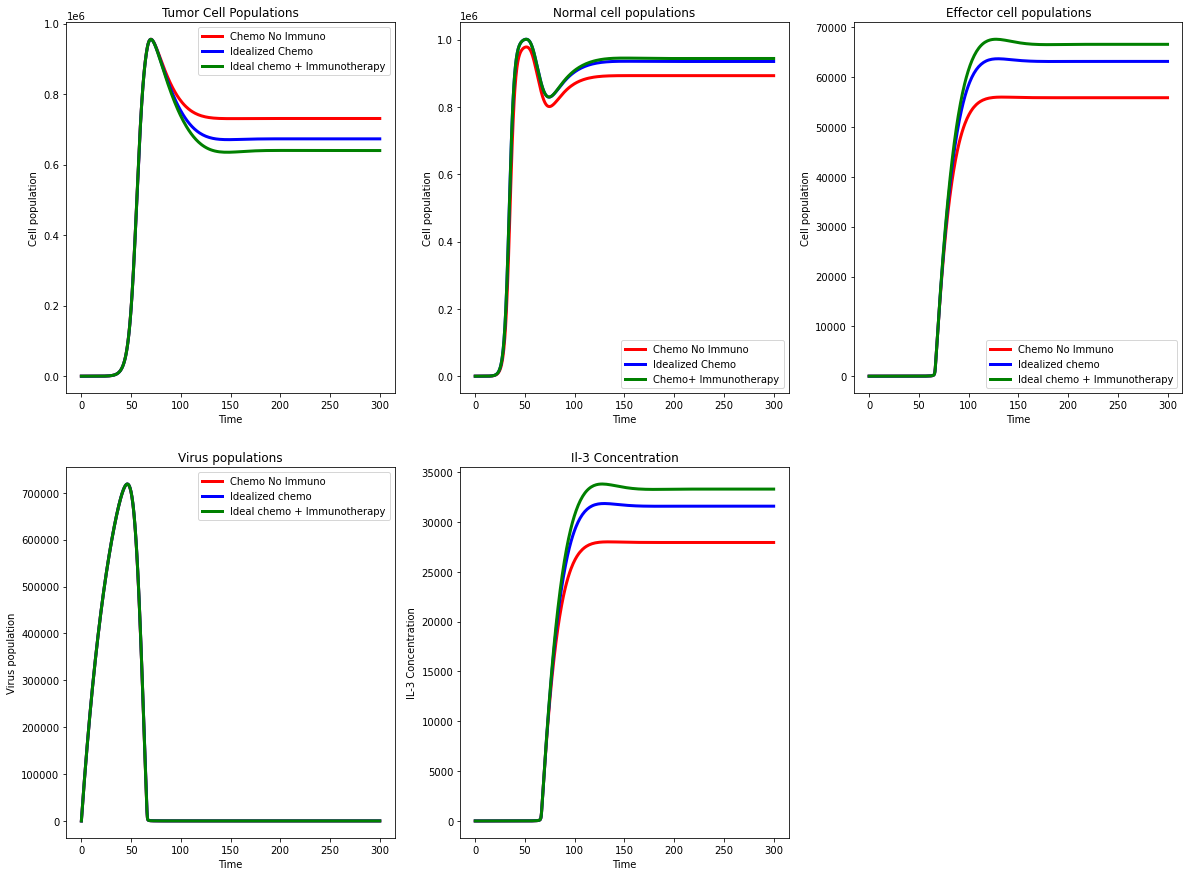

In [8]:
#########3 Case Studies ##########
fig5 = plt.figure(5, figsize =(20,15) )
ax1 = fig5.add_subplot(2,3,1)
ax2 = fig5.add_subplot(2,3,2)
ax3 = fig5.add_subplot(2,3,3)
ax4 = fig5.add_subplot(2,3,4)
ax5 = fig5.add_subplot(2,3,5)
ax1.plot(enh.t, enh.y[0], color='red', linewidth=3, label ="Chemo No Immuno")
ax1.plot(enh_ideal_chemo.t, enh_ideal_chemo.y[0], color='blue', linewidth=3, label ="Idealized Chemo")
ax1.plot(enh_immune_boost.t, enh_immune_boost.y[0], color='green', linewidth=3, label ="Ideal chemo + Immunotherapy")


ax2.plot(enh.t, enh.y[1], color='red', linewidth=3, label ="Chemo No Immuno")
ax2.plot(enh_ideal_chemo.t, enh_ideal_chemo.y[1], color='blue', linewidth=3, label ="Idealized Chemo")
ax2.plot(enh_immune_boost.t, enh_immune_boost.y[1], color='green', linewidth=3, label ="Chemo+ Immunotherapy")

ax3.plot(enh.t, enh.y[2], color='red', linewidth=3, label ="Chemo No Immuno")
ax3.plot(enh_ideal_chemo.t, enh_ideal_chemo.y[2], color='blue', linewidth=3, label ="Idealized chemo")
ax3.plot(enh_immune_boost.t, enh_immune_boost.y[2], color='green', linewidth=3, label ="Ideal chemo + Immunotherapy")

ax4.plot(enh.t, enh.y[4], color='red', linewidth=3, label ="Chemo No Immuno")
ax4.plot(enh_ideal_chemo.t, enh_ideal_chemo.y[4], color='blue', linewidth=3, label ="Idealized chemo")
ax4.plot(enh_immune_boost.t, enh_immune_boost.y[4], color='green', linewidth=3, label ="Ideal chemo + Immunotherapy")

ax5.plot(enh.t, enh.y[3], color='red', linewidth=3, label ="Chemo No Immuno")
ax5.plot(enh_ideal_chemo.t, enh_ideal_chemo.y[3], color='blue', linewidth=3, label ="Idealized chemo")
ax5.plot(enh_immune_boost.t, enh_immune_boost.y[3], color='green', linewidth=3, label ="Ideal chemo + Immunotherapy")

ax1.set_xlabel('Time')
ax1.set_ylabel('Cell population')
ax1.set_title("Tumor Cell Populations")
ax2.set_xlabel('Time')
ax2.set_ylabel('Cell population')
ax2.set_title("Normal cell populations")
ax3.set_xlabel('Time')
ax3.set_ylabel('Cell population')
ax3.set_title("Effector cell populations")
ax4.set_xlabel('Time')
ax4.set_ylabel('Virus population')
ax4.set_title("Virus populations")
ax5.set_xlabel('Time')
ax5.set_ylabel('IL-3 Concentration')
ax5.set_title("Il-3 Concentration")
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
plt.show()

### Testing Various Scenarios & Comparing the Base and Enhanced Models

As we can see above: 

Scenario 1 -Red ) Chemotherapy present, no immunotherapy: In this case, we can observe a "baseline" behavior. Tumor cell concentrations decrease just as effector cell concentrations increase, shortly passing t=50. Just as before, normal cell populations downturn sharply at the point where tumor cells increase sharply. However, in contrast to the original model, where normal cells continuously decreased after the tumor cell population reached equilibrium, the normal cell populations actually make a recovery here. They reach an equilibrium population which, while less than their initial population, is far better than the no-chemotherapy alternative. This difference in behavior of tumor and normal cells is the key difference between the previous model and this iteration. 

Scenario 2 - Blue) Ideal Chemotherapy: In this case, we reduce the "killing side effects" of chemotherapy by a factor of 10- we reduce the coefficients for drug toxicity on normal and effector cells from .01 to .001. As a result, we can see the amount of normal cells is greater compared to a less ideal chemotherapy, without sacrificing efficacy in eliminating tumor cells - just as "ideal" as we would want. 

Scenario 3 - Green) Ideal chemotherapy + Immunotherapy: We can see that this is the most effective method in terms of keeping tumor cells low, and normal + effector cells high. Its steady state populations of desirable cells is an improvement compared to the other scenarios. 

Effector cells: We can observe that effector cells start growing right around the same time as when IL-3 concentrations increase, which both follow from Tumor cells reaching the maximum tumor size at T(t)=300,000. 

Virus population diagram: The virus population, immunodeficiency viruses which reduce to some extent the effector cell population, depends only on the effector cell population and the initial virus population. As effector cells start rising in population, viruses are killed out with haste; once their population is exhausted, they cannot return. 

## Part 2: Exploring the Effects of Different Solvers

Let's try a few things (this might take a few seconds extra to run). We already have LSODA, let's compare it with bdf and RK45 for the amount of time it takes to solve. This way, we look at an explicit, implicit, and Adams method (since LSODA is an Adams/BDF method with automatic stiffness detection and switching). In this case, we'll keep using the case of Immunotherapy + Ideal Chemotherapy since it has the most interesting equilibrium behaviour. In this section, I'm taking some inspiration from this paper to guide how I benchmark the three solvers: https://www.nature.com/articles/s41598-021-82196-2.pdf

In [9]:
base = time.perf_counter()
enhanced_model_rk45 = solve_ivp(f, t_long, immune_initial_conditions, args = (params,immune_params,drug_params,), method='RK45')
rk_time = time.perf_counter()
enhanced_model_bdf = solve_ivp(f, t_long, immune_initial_conditions, args = (params,immune_params,drug_params,), method='BDF')
bdf_time = time.perf_counter()
enhanced_model_LSODA = solve_ivp(f, t_long, immune_initial_conditions, args = (params,immune_params,drug_params,), method='LSODA')
lsoda_time= time.perf_counter()
lsoda_time = lsoda_time-bdf_time
bdf_time = bdf_time-rk_time
rk_time = rk_time-base
#print(rk_time,bdf_time,lsoda_time)

My first thought was to check the outputs for each t-value, and see how close together they were, which I tried to do below for just two of 3 of the tested models, without much success. 

They don't pass the tests-- they aren't close enough together. I've checked the last value of tumor cell populations here as a test case. Instead of looking at the results directly against each other, I'll now look at the amount of time it takes to implement solve_ivp with each method for each of a list of tolerances. This is because, if I want to keep a certain level of error checking, I'll likely want to pick the implementation that gives me the most accurate results in the least amount of time. The first time we originally calculated with each of the 3 methods, RK45 took about 67 times longer than BDF or LSODA- and that's before adding in any kind of tolerance which only increases the runtime. Of course, runtime also can vary a lot from instance to instance, so this should really be run another 50+times and averaged, but that would take a minute and for our basic purposes it's fine.  The following code will take a good solid few seconds seconds to load. In case it doesn't I'll attach a screenshot from one of the times I ran it myself. 

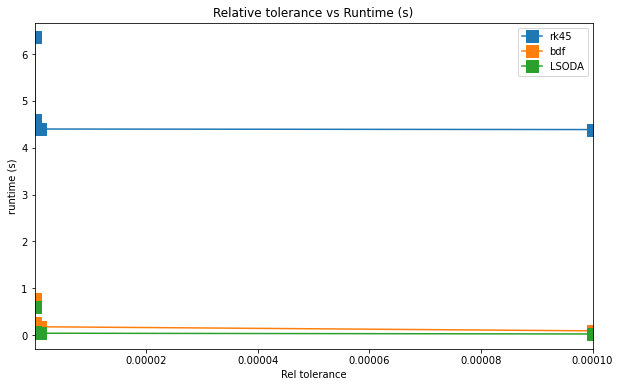

In [10]:
###For a list of absolute and relative tolerances, calculating the running times

rtols = [.0001,.000001, .0000001, .0000000001]
atols=[.0000001, .000000001, .0000000001, .000000000001]

rk45_run =[]
bdf_run=[]
lsoda_run=[]

for rtol, atol in zip(rtols, atols):
    a = time.perf_counter()
    solve_ivp(f, t_long, immune_initial_conditions, args = (params,immune_params,drug_params,), method='RK45', rtol=rtol, atol=atol)
    b=time.perf_counter()
    solve_ivp(f, t_long, immune_initial_conditions, args = (params,immune_params,drug_params,), method='BDF', rtol=rtol, atol=atol)
    bdft = time.perf_counter()
    solve_ivp(f, t_long, immune_initial_conditions, args = (params,immune_params,drug_params,), method='LSODA', rtol=rtol, atol=atol)
    lsodat = time.perf_counter()
    lsoda_run.append(lsodat-bdft)
    bdf_run.append(bdft-b)
    rk45_run.append(b-a)

#plotting tolerances vs running time
fig20 = plt.figure(20, figsize=(10,6))
ax1 = fig20.add_subplot()
ax1.plot(rtols,rk45_run, label='rk45', marker='s', markersize='12')
ax1.plot(rtols, bdf_run, label='bdf', marker='s', markersize='12')
ax1.plot(rtols,lsoda_run, label='LSODA', marker='s', markersize='12')
ax1.set_title("Relative tolerance vs Runtime (s)")
ax1.set_ylabel("runtime (s)")
ax1.set_xlabel("Rel tolerance")
ax1.set_xlim(.000000000001,.0001)
ax1.legend()

Although the exact times can vary a bit, LSODA yields the most efficient runtime, usually being more than twice as fast as RK45. This can vary, but the overall hierarchy is definitely consistent with LSODA always being the fastest and RK-45 being the slowest. BDF and LSODA also slow down way less for high tolerances as compared to rk45, which slow down very signficiantly as the tolerances are decreased. 

### Why LSODA?

LSODA uses Adams methods, implicit methods, for non-stiff problems. For stiff problems, LSODA actually just uses BDF. LSODA uses eigenvalues to estimate how stiff the ODE is, and switches algorithms when it needs to in order to minimize error; that's why LSODA is able to be so efficient with the time, even with relatively quite restrictive tolerances. In my case, I just went with it because I saw low error and speedy computation, and I didn't have a need for a specific solver for any other reason. 

## Part 3: Exploring Model Kinetics

In this section, I'll explore the kinetics of the model with regard to 4 of the variables/combos of the variables. First, I will test how the model responds to increasing the interaction coefficients between different actors in this system. Next, to observe therapeutic implications, I will vary the dosage of the immunotherapy in isolation, followed by different combinations of increased and decreased chemotherapy and immunotherapy.

### Varying Cell Interaction Coefficients-Tumor-normal interaction rate - Isolated

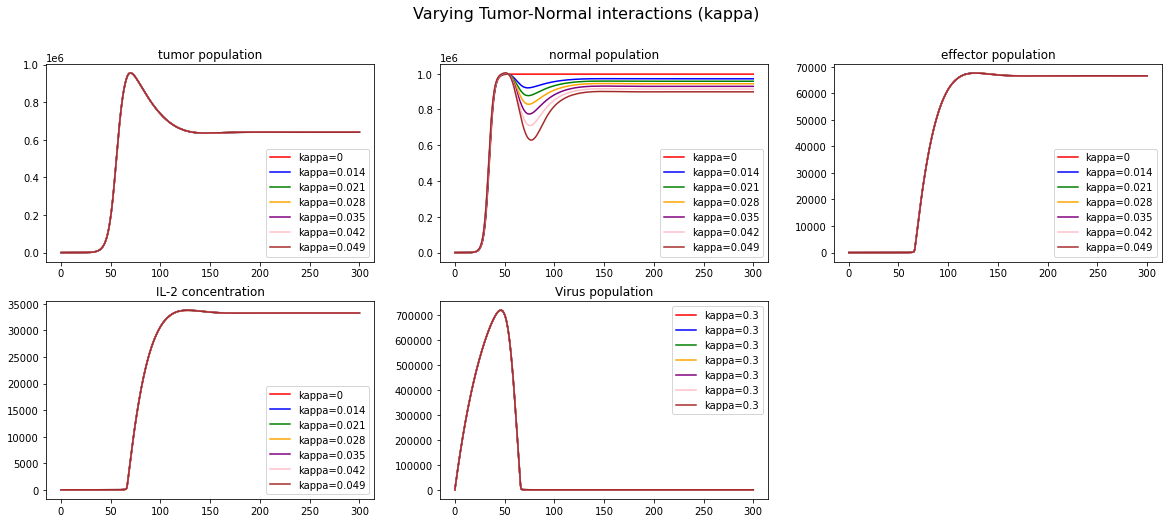

In [11]:
# We have 3 sets of parameters
#params = [T_star, k_T, k_N, r_T, r_N, kappa, beta, rho_0, rho_1]
#immune_params = a,b,c,g_1, g_2, g_3, u_1, u_2, u_3, p_1, p_2, alpha, eta, gamma 
#drug_params = a_T, a_N, a_E, a_EE
count=0
##FIRST, WE VARY: Interaction coefficients
fig8 = plt.figure(8, figsize=(20,8))
fig8.suptitle("Varying Tumor-Normal interactions (kappa)", fontsize=16)
kappas = [0,.014,.021,.028,.035,.042,.049]
cell_params_betavar =[]
cellint_variants=[]
for kee in kappas:
    cell_params_betavar.append([T_star, k_T, k_N, r_T, r_N, kee, beta, rho_0, rho_1])
for cellint in cell_params_betavar:
    cellint_variants.append((solve_ivp(f, t_long, immune_initial_conditions, args = (cellint, immune_params, drug_params), method='LSODA'),cellint))
colors = ['red','blue','green','orange', 'purple', 'pink', 'brown']
ax1 = fig8.add_subplot(2,3,1)
ax1.set_title("tumor population")
ax2=fig8.add_subplot(2,3,2)
ax2.set_title("normal population")
ax3=fig8.add_subplot(2,3,3)
ax3.set_title("effector population")
ax4=fig8.add_subplot(2,3,4)
ax4.set_title("IL-2 concentration")
ax5=fig8.add_subplot(2,3,5)
ax5.set_title("Virus population")
for var in cellint_variants:
    color = colors[count]
    ax1.plot(var[0].t, var[0].y[0], color=color, label=("kappa={}".format(var[1][5])))
    ax2.plot(var[0].t, var[0].y[1], color=color, label=("kappa={}".format(var[1][5])))
    ax3.plot(var[0].t, var[0].y[2], color=color, label=("kappa={}".format(var[1][5])))
    ax4.plot(var[0].t, var[0].y[3], color=color, label=("kappa={}".format(var[1][5])))
    ax5.plot(var[0].t, var[0].y[4], color=color, label=("kappa={}".format(var[1][3])))
    count+=1
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()

Manipulating kappa only shows a significant difference on normal populations, which we might have predicted given that kappa affects tumor-normal populations (as opposed to beta which affects normal-tumor interactions, and would affect tumor populations). Given how the system is written, an increase in the normal cell population would actually not have much of an impact on other terms. N only appears in the normal cell population equation. 

Next, let's look at changing beta and kappa together. 

### Changing Beta and Kappa - Normal-tumor and Tumor-normal interaction rates

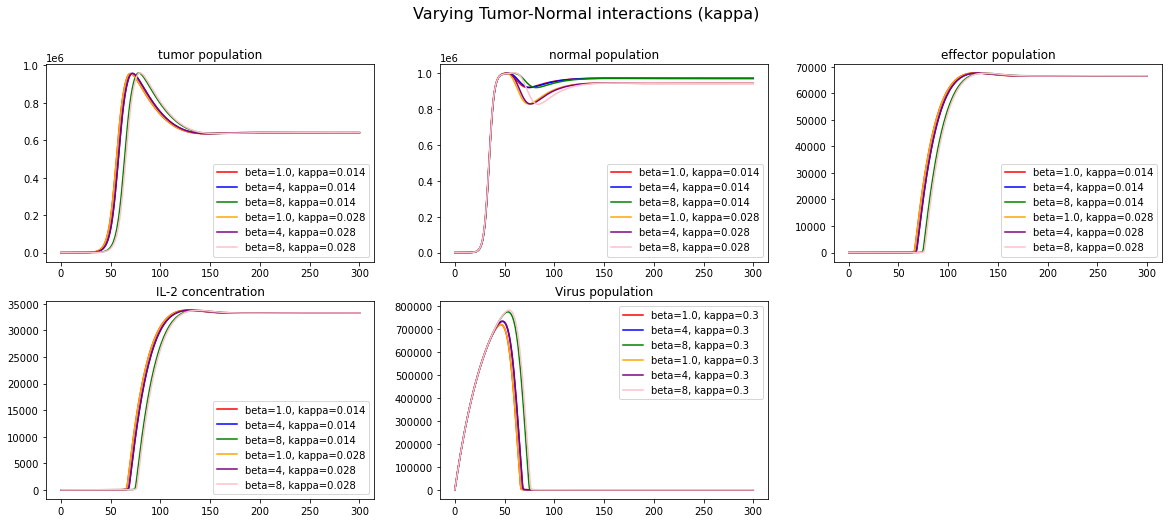

In [12]:
fig9 = plt.figure(9, figsize=(20,8))
fig9.suptitle("Varying Tumor-Normal interactions (kappa)", fontsize=16)
kappas = [.014,.028]
betas = [1.0,4,8]
cell_params_betavar =[]
cellint_variants=[]
for kee in kappas:
    for bee in betas:
        cell_params_betavar.append([T_star, k_T, k_N, r_T, r_N, kee, bee, rho_0, rho_1])
for cellint in cell_params_betavar:
    cellint_variants.append((solve_ivp(f, t_long, immune_initial_conditions, args = (cellint, immune_params, drug_params), method='LSODA'),cellint))
colors = ['red','blue','green','orange', 'purple', 'pink', 'brown', 'black', 'turquoise', 'olive', 'yellow', 'slategrey']
ax1 = fig9.add_subplot(2,3,1)
ax1.set_title("tumor population")
ax2=fig9.add_subplot(2,3,2)
ax2.set_title("normal population")
ax3=fig9.add_subplot(2,3,3)
ax3.set_title("effector population")
ax4=fig9.add_subplot(2,3,4)
ax4.set_title("IL-2 concentration")
ax5=fig9.add_subplot(2,3,5)
ax5.set_title("Virus population")
count=0
for var in cellint_variants:
    color = colors[count]
    ax1.plot(var[0].t, var[0].y[0], color=color, label=("beta={}, kappa={}".format(var[1][6], var[1][5])))
    ax2.plot(var[0].t, var[0].y[1], color=color, label=("beta={}, kappa={}".format(var[1][6], var[1][5])))
    ax3.plot(var[0].t, var[0].y[2], color=color, label=("beta={}, kappa={}".format(var[1][6], var[1][5])))
    ax4.plot(var[0].t, var[0].y[3], color=color, label=("beta={}, kappa={}".format(var[1][6], var[1][5])))
    ax5.plot(var[0].t, var[0].y[4], color=color, label=("beta={}, kappa={}".format(var[1][6], var[1][3])))
    count+=1
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()

First of all, the model scarcely changes for very large changes in beta, as increasing beta by 3 or even 7 only serves to shift the curves left slightly. Secondly, we can observe the shifts caused by changes in kappa are not cross-influenced by any of the changes to kappa - they just stack. Again, nothing crazy here - higher interactions between tumor/normal and normal/tumor cells just means that we'd reach the maximum tumor size slightly faster, accelerating the whole process without otherwise altering it much. 

The much more interesting interactions are with regard to the drug parameters- the chemotherapy/immunotherapy dosage effects - which we can look at next. 

### Varying Chemotherapy Dosage - Isolated

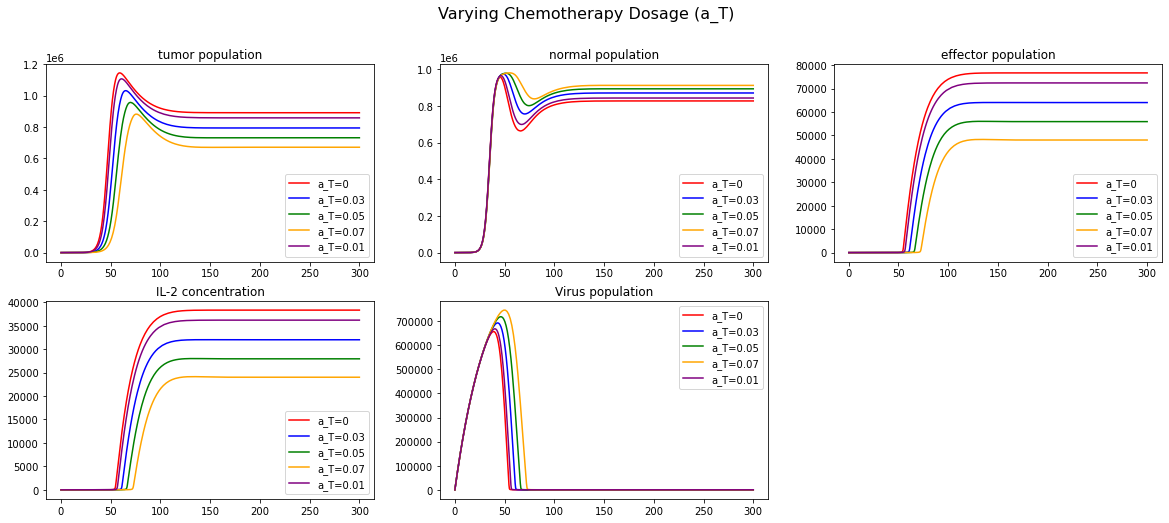

In [13]:
a_T, a_N, a_E, a_EE = [0.05,.01,.01,0]
drug_params = [a_T, a_N, a_E, a_EE]
count=0
##WE VARY: Chemo dosage
fig7 = plt.figure(7, figsize=(20,8))
fig7.suptitle("Varying Chemotherapy Dosage (a_T)", fontsize=16)
aTs = [0,.03,.05,.07,.01]
drug_params_aTvar =[]
immunotherapy_variants=[]
for aT in aTs:
    drug_params_aTvar.append([aT, a_N, a_E, a_EE])
for dpTT in drug_params_aTvar:
    immunotherapy_variants.append((solve_ivp(f, t_long, immune_initial_conditions, args = (params, immune_params, dpTT), method='LSODA'),dpTT))
colors = ['red','blue','green','orange', 'purple', 'pink', 'brown']
ax1 = fig7.add_subplot(2,3,1)
ax1.set_title("tumor population")
ax2=fig7.add_subplot(2,3,2)
ax2.set_title("normal population")
ax3=fig7.add_subplot(2,3,3)
ax3.set_title("effector population")
ax4=fig7.add_subplot(2,3,4)
ax4.set_title("IL-2 concentration")
ax5=fig7.add_subplot(2,3,5)
ax5.set_title("Virus population")
for var in immunotherapy_variants:
    color = colors[count]
    ax1.plot(var[0].t, var[0].y[0], color=color, label=("a_T={}".format(var[1][0])))
    ax2.plot(var[0].t, var[0].y[1], color=color, label=("a_T={}".format(var[1][0])))
    ax3.plot(var[0].t, var[0].y[2], color=color, label=("a_T={}".format(var[1][0])))
    ax4.plot(var[0].t, var[0].y[3], color=color, label=("a_T={}".format(var[1][0])))
    ax5.plot(var[0].t, var[0].y[4], color=color, label=("a_T={}".format(var[1][0])))
    count+=1
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()

Adjusting the chemotherapy dosage varies exactly how you would expect it to - essentially, increased chemotherapy leads to decreased tumor population, and increased normal cell populations. However, effector cell populations and IL-2 concentrations vary inversely, likely because effector cell populations depend only on tumor cell population levels, not normal cell population levels-- they show up to fight the tumor cells, otherwise, their presence can be inflammatory to normal cells. So far, so good. 

### Varying Immunotherapy Dosage - Isolated

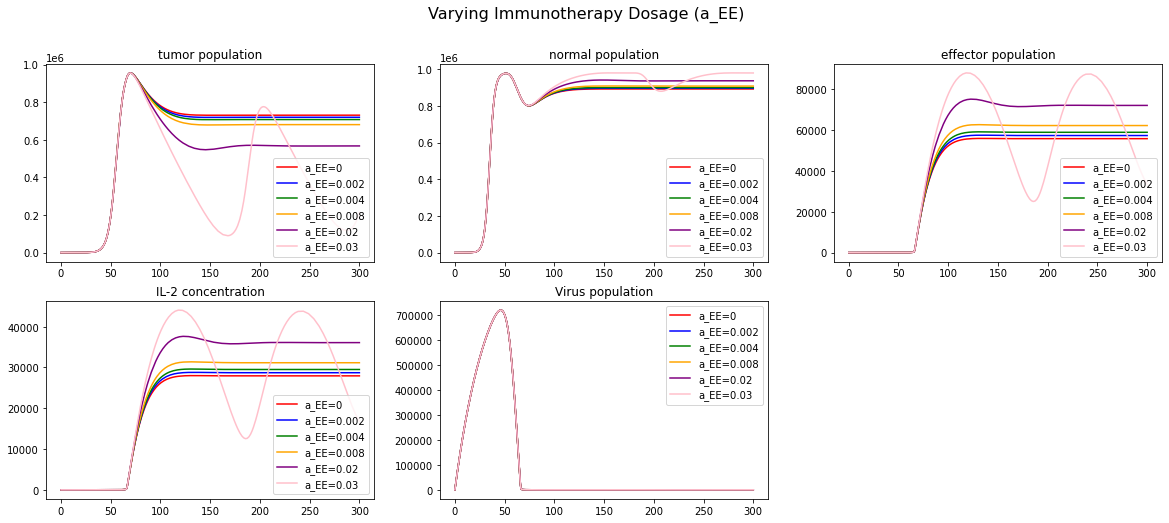

In [14]:
a_T, a_N, a_E, a_EE = [0.05,.01,.01,0]
drug_params = [a_T, a_N, a_E, a_EE]
count=0
##FIRST, WE VARY: Immunotherapy dosage
fig6 = plt.figure(6, figsize=(20,8))
fig6.suptitle("Varying Immunotherapy Dosage (a_EE)", fontsize=16)
#aEEs = [0,.002,.004,.008,.02,.04,.08]
aEEs = [0,.002,.004,.008,.02,.03]
drug_params_aEEvar =[]
immunotherapy_variants=[]
for aEE in aEEs:
    drug_params_aEEvar.append([a_T, a_N, a_E, aEE])

for dpEE in drug_params_aEEvar:
    immunotherapy_variants.append((solve_ivp(f, t_long, immune_initial_conditions, args = (params, immune_params, dpEE), method='LSODA'),dpEE))
colors = ['red','blue','green','orange', 'purple', 'pink', 'brown']
ax1 = fig6.add_subplot(2,3,1)
ax1.set_title("tumor population")
ax2=fig6.add_subplot(2,3,2)
ax2.set_title("normal population")
ax3=fig6.add_subplot(2,3,3)
ax3.set_title("effector population")
ax4=fig6.add_subplot(2,3,4)
ax4.set_title("IL-2 concentration")
ax5=fig6.add_subplot(2,3,5)
ax5.set_title("Virus population")
for var in immunotherapy_variants:
    color = colors[count]
    ax1.plot(var[0].t, var[0].y[0], color=color, label=("a_EE={}".format(var[1][3])))
    ax2.plot(var[0].t, var[0].y[1], color=color, label=("a_EE={}".format(var[1][3])))
    ax3.plot(var[0].t, var[0].y[2], color=color, label=("a_EE={}".format(var[1][3])))
    ax4.plot(var[0].t, var[0].y[3], color=color, label=("a_EE={}".format(var[1][3])))
    ax5.plot(var[0].t, var[0].y[4], color=color, label=("a_EE={}".format(var[1][3])))
    count+=1
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()

As we increase the immunotherapy dosages, we observe a huge oscillatory behavior in cell populations and IL-2 concentrations-- much, much different from increasing the chemotherapy dosage in isolation. If you increase the immunotherapy dosage much beyond 0.3, the maximum tested here, the model goes crazy. You can see that the oscillations are opposite for the tumor population vs the normal/effector populations and IL-2 concentration. The oscillatory behaviours are coming from the drug toxicity term, and it makes sense, because at its core, that term is $\phi^\prime = a_{EE}\phi$ which, as a_EE increases, becomes more significant. It is reflective of natural processes to some extent since immunotherapy usually administered much closer to a_EE=0.002 than 0.02. 

### Varying Immunotherapy WITH Chemotherapy 

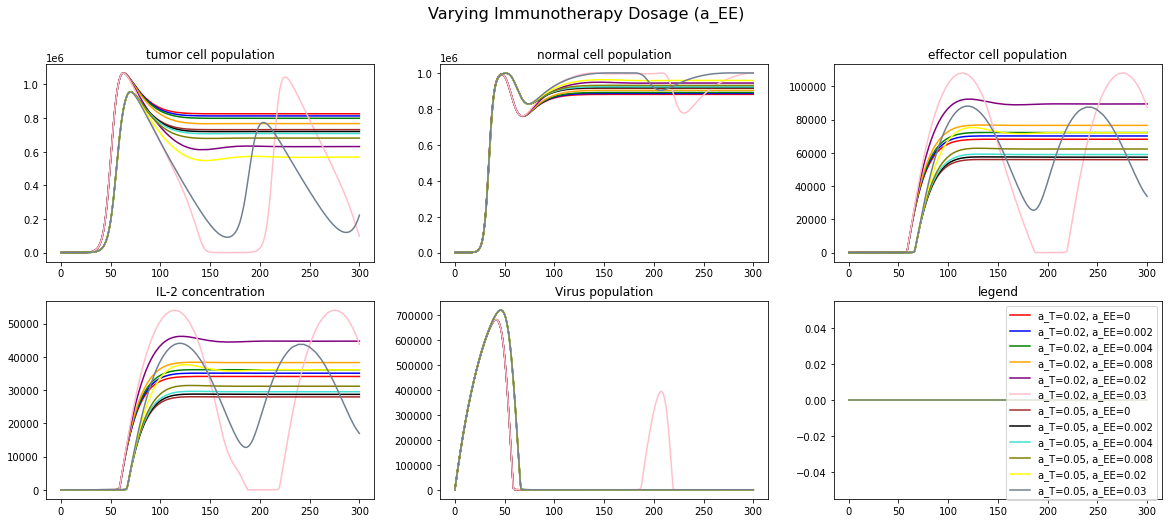

In [15]:
a_T, a_N, a_E, a_EE = [0.05,.01,.01,0]
drug_params = [a_T, a_N, a_E, a_EE]
count=0
fig10 = plt.figure(10, figsize=(20,8))
fig10.suptitle("Varying Immunotherapy Dosage (a_EE)", fontsize=16)
aTs = [0.02,.05]
a_N= 0.001
a_e=.001
aEEs = [0,.002,.004,.008,.02,.03]
drug_params_aEEvar =[]
immunotherapy_variants=[]
for aT in aTs:
    for aE in aEEs:
        drug_params_aEEvar.append([aT, a_N, a_E, aE])
for dpEE in drug_params_aEEvar:
    immunotherapy_variants.append((solve_ivp(f, t_long, immune_initial_conditions, args = (params, immune_params, dpEE), method='LSODA'),dpEE))
colors = ['red','blue','green','orange', 'purple', 'pink', 'brown', 'black', 'turquoise', 'olive', 'yellow', 'slategrey']
ax1 = fig10.add_subplot(2,3,1)
ax1.set_title("tumor cell population")
ax2=fig10.add_subplot(2,3,2)
ax2.set_title("normal cell population")
ax3=fig10.add_subplot(2,3,3)
ax3.set_title("effector cell population")
ax4=fig10.add_subplot(2,3,4)
ax4.set_title("IL-2 concentration")
ax5=fig10.add_subplot(2,3,5)
ax5.set_title("Virus population")
ax6=fig10.add_subplot(2,3,6)
ax6.set_title("legend")
count=0
for var in immunotherapy_variants:
    color = colors[count]
    ax1.plot(var[0].t, var[0].y[0], color=color, label=("a_T={}, a_EE={}".format(var[1][0], var[1][3])))
    ax2.plot(var[0].t, var[0].y[1], color=color, label=("a_T={}, a_EE={}".format(var[1][0], var[1][3])))
    ax3.plot(var[0].t, var[0].y[2], color=color, label=("a_T={}, a_EE={}".format(var[1][0], var[1][3])))
    ax4.plot(var[0].t, var[0].y[3], color=color, label=("a_T={}, a_EE={}".format(var[1][0], var[1][3])))
    ax5.plot(var[0].t, var[0].y[4], color=color, label=("a_T={}, a_EE={}".format(var[1][0], var[1][3])))
    ax6.plot(var[0].t, numpy.zeros(var[0].t.shape), color=color, label=("a_T={}, a_EE={}".format(var[1][0], var[1][3])))
    count+=1
ax6.legend()

As you can see, things start to go crazy here. First of all, the vast majority of cases behaved as expected, with the same oscillations or upward/downward shifts that we expected from the two isolated studies of chemotherapy dosage and immunotherapy dosage. It's only in situations with extremely high doses of both immunotherapy and chemotherapy that issues start arising. For example, the pink curve, where a_T and a_EE are both super high, we see extremely high oscillations. This does make some sense to me, because we've increased the coefficient of the terms that cause oscillation simultaneously. It, to some extent, does also reflect natural phenomena, as administering chemotherapeutic/immunotherapeutic agents at doses that high would be highly toxic and unrealistic. 


## Part 4: The addition of drug resistance for Chemotherapy

Something the original authors didn't add was drug resistance, for either chemotherapy or immunotherapy. Literature has established a somewhat standard procedure for this, and I am adapting the model set in this paper [1] by Witten. I thought it could be interesting to try incorporating this into the model as well, to see how it could affect tumor and normal cell populations over time. In this situation, I will only be modelling the effect of drug resistance on chemotherapy, both for simplicity's sake and also because the process of developing resistance for immunotherapy is less straightforward than the process of developing resistance for chemotherapy. 

There are multiple mechanisms for drug resistance, like pharmacological resistance, where the drug can no longer effectively reach or target the tumor cells. Here, I'll focus on the kind driven by cell mutation, where proportions of tumor cells are much less susceptible to chemotherapy. These cells keep dividing, making the overall tumor much harder to treat with chemotherapy. I've added resistant tumor cells to the model below.

$$\frac{dT}{dt} = r_T T\left(1-\frac{T+T_r}{K_T}\right)- cT - \frac{aE(T+T_r)}{g_2 + T+T_r} -a_TT$$
$$\frac{dT_r}{dt} = r_{Tr} T_r\left(1-\frac{T+T_r}{K_T}\right)+ cT - \frac{aE(T+T_r)}{g_2 + T+T_r} -a_{Tr}T_r$$
$$\frac{dN}{dt} = r_N N\left(1-\frac{N}{K_N}\right)- \kappa (T+T_r) \left(1-\frac{T+T_r}{T^*} \right)-a_N*N$$
$$\frac{dE}{dt} = c(T+T_r) - \mu_2 E + \frac{p_1 EI}{g_1 +I} - \alpha VE - a_E(1-e^{-\xi MC})E - a_{EE}*E$$
$$\frac{dI}{dt} = \frac{p_2 (T+T_r)E}{g_3 + T+T_2}-\mu_3I $$
$$\frac{dV}{dt} = \frac{\eta V}{b+ V} - \gamma VE - \mu_1 V$$

 As you can see here, I've added in a T_r term, for resistant tumor cells. It comes with one new variable, r_Tr (its growth rate), which I have set to be slightly larger than the growth rate of a normal tumor cell. 

[1] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4429337/pdf/12976_2014_Article_505.pdf

In [16]:
###implementation
a_T, a_N, a_E, a_EE = [0.05,.01,.01,0]
drug_params = [a_T, a_N, a_E, a_EE]
r_Tr = 0.35
a_Tr = 0.04
new_immune_initial_condition = [1,1,1,1,1,1]
new_vars=[r_Tr, a_Tr]
def f_modif(t, new_immune_initial_condition, params, immune_params, drug_params, new_vars):
    T,T_r, N, E, I, V = new_immune_initial_condition
    T_star, k_T, k_N, r_T, r_N, kappa, beta, rho_0, rho_1 = params
    a,b,c,g_1, g_2, g_3, u_1, u_2, u_3, p_1, p_2, alpha, eta, gamma = immune_params
    a_T, a_N, a_E, a_EE = drug_params
    r_Tr, a_Tr=new_vars
    derivs = [(r_T*T*(1-(T+T_r/k_T))-c*T -a_T*T),
              (r_Tr*T_r*(1-(T+T_r/k_T))+c*T-(a*E*(T+T_r))/(g_2+T+T_r)+a_Tr*T_r),
             (r_N*N*(1-N/k_N)+kappa*(T+T_r)*(1-(T+T_r)/T_star)-a_N*N),
             (c*(T+T_r)-u_2*E + (p_1*E*I)/(g_1+I)-alpha*V*E-a_E*E +a_EE*E),
             ((p_2*(T+T_r)*E)/(g_3+T+T_r)-u_3*I),
             ((eta*V)/(b+V)-gamma*V*E-u_1*V)]
    return derivs

In [17]:
#######INITIAL CONDITION#######
T, N, E, I, V = [1,1,1,1,1]
T_star, k_T, k_N, r_T, r_N, kappa, beta, rho_0, rho_1 = params
a,b,c,g_1, g_2, g_3, u_1, u_2, u_3, p_1, p_2, alpha, eta, gamma = immune_params
a_T, a_N, a_E, a_EE = drug_params
T,T_r, N, E, I, V = [1,1,1,1,1,1]
a_T, a_N, a_E, a_EE = [0.05,.01,.01,0]
drug_params = [a_T, a_N, a_E, a_EE]
r_Tr = 0.35
a_Tr = 0.02
new_vars=[r_Tr, a_Tr]
new_immune_initial_condition = [1,1,1,1,1,1]
l = f_modif(t, new_immune_initial_condition, params, immune_params, drug_params, new_vars)

new_vars=[r_Tr, a_Tr]
answer =  [(r_T*T*(1-(T+T_r/k_T))-c*T -a_T*T),
              (r_Tr*T_r*(1-(T+T_r/k_T))+c*T-(a*E*(T+T_r))/(g_2+T+T_r)+a_Tr*T_r),
             (r_N*N*(1-N/k_N)+kappa*(T+T_r)*(1-(T+T_r)/T_star)-a_N*N),
             (c*(T+T_r)-u_2*E + (p_1*E*I)/(g_1+I)-alpha*V*E-a_E*E +a_EE*E),
             ((p_2*(T+T_r)*E)/(g_3+T+T_r)-u_3*I),
             ((eta*V)/(b+V)-gamma*V*E-u_1*V)]
numpy.testing.assert_allclose(l, answer)
print('modified version initial condition success!')

modified version initial condition success!


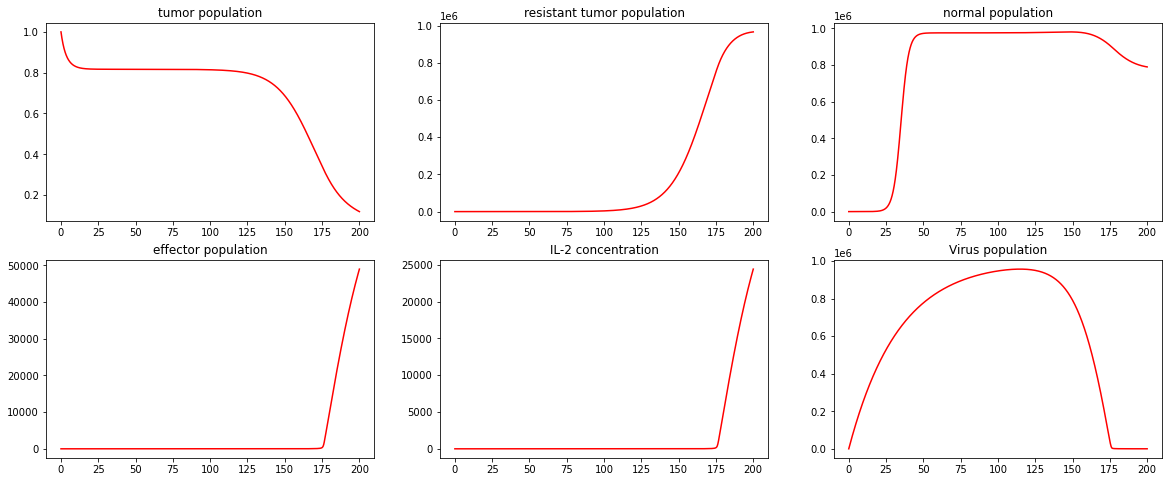

In [18]:
################NOTE: this code might take a minute to run!
###Graphing a use case

params=T_star, k_T, k_N, r_T, r_N, kappa, beta, rho_0, rho_1
immune_params=a,b,c,g_1, g_2, g_3, u_1, u_2, u_3, p_1, p_2, alpha, eta, gamma
drug_params=a_T, a_N, a_E, a_EE

pps=[1]
variants = []
var=(solve_ivp(f_modif, t,[1,1,1,1,1,1],args = (params, immune_params, drug_params, new_vars)),[1,2])
colors = ['red','blue','green','orange', 'purple', 'pink', 'brown', 'black', 'turquoise', 'olive', 'yellow', 'slategrey']
fig15 = plt.figure(15, figsize = (20,8))
ax1 = fig15.add_subplot(2,3,1)
ax1.set_title("tumor population")
ax6 = fig15.add_subplot(2,3,2)
ax6.set_title("resistant tumor population")
ax2=fig15.add_subplot(2,3,3)
ax2.set_title("normal population")
ax3=fig15.add_subplot(2,3,4)
ax3.set_title("effector population")
ax4=fig15.add_subplot(2,3,5)
ax4.set_title("IL-2 concentration")
ax5=fig15.add_subplot(2,3,6)
ax5.set_title("Virus population")
count=0
#print(var)
color = colors[count]
ax1.plot(var[0].t, var[0].y[0], color=color )
ax2.plot(var[0].t, var[0].y[2], color=color)
ax3.plot(var[0].t, var[0].y[3], color=color)
ax4.plot(var[0].t, var[0].y[4], color=color)
ax5.plot(var[0].t, var[0].y[5], color=color)
ax6.plot(var[0].t, var[0].y[1], color=color)

As you can see above, the drug resistant tumor cells increase more aggressively than the normal tumor cells- that makes sense, as the only thing that could kill them would be chemotherapy or effector cells-- and chemotherapy doesn't work. We can also see how the effector cell populations grow with the total tumor population,not just the normal tumor population, as we would expect. Finally, the IL-2 population goes up as the total tumor population increases. Our virus graph changes as well since it depends on the effector cell population-- it actually hits a new maximum, indicating even more trouble for the system, as the increased virus populations attack the effector cells. Overall, the graphs definitely look a little bit funky. For instance--the tumor population should not be starting from 1 and decreasing, and it definitely shouldn't be 1 at all- it should be way larger, on the order of hundred-thousands like the resistant tumor cells. I suspect this is due to . 

## Discussion 

1) My test cases worked when I checked on the initial conditions, and, although I don't have access to the original authors' results to verify my model computationally, the results from a few test cases I did with matching parameters came back with matching graphs in terms of overall behavior, values/intercepts, etc. For the part I implemented independently, with drug resistance, what I introduced can definitely be modeled in a more nuanced way, but the way I implemented it expresses a few parts of the expected behaviour so far. A more sophisticated model would almost definitely include something timestop-related in incorporating the growth of resistance over time, which I did not do. You can see that effect in the curves above -it's not the most realistic representation, at all. A better model would also 

2) The project did work, in my opinion! First of all, the implementation itself functions in all 3 models: the base model, the enhanced model with immunotherapy and chemotherapy, and in my modification with chemotherapy drug resistance. Also, for the first two, the behavior seems to gel (in a broad sense) with expected natural phenomena. Of course, it's when you're making a model with expectations on how it behaves since it turns into a bit of a self fulfilling prophecy, but as a first step this seems okay. The one part of the model which did not work as intended was the drug resistance section. The tumor cell population function's behaviour was not as predicted, and that would be a first target for improvement in a next iteration of this project. 

3) Some potential next steps: As I said earlier, the first thing I'd want to fix would be the drug resistance model. In order to fix it, as opposed to starting with my current (complicated) model and adding in drug resistance, I might start with adding drug resistance to the simple/base model first, then, after seeing how it behaves, move parts of it into a more complicated model. I didn't go with this approach this time and it made troubleshooting cumbersome. There's definitely something to be said for iterating over a series of models when developing/adding to the design. I would also consider condensing/scaling the system so it can run in a more efficient vectorized form. Obviously, there are tons of variables in this model -- because this is reflecting a very complicated biological system -- but streamlining the system could be beneficial. A more parsimonious model would definitely be easier to work with and might improve the computational efficiency if this model is to be scaled. Also, it could be really interesting to compare this logistic model of growth against a totally different model for tumor growth that also includes immunotherapy and chemotherapy, such as exponential or Gompertz growth [1]. In my short look over at the literature, I didn't find any models that were already a good match for direct comparison but there are tons of models which could be adapted and compared, which could give interesting insights into how different model design choices affect tumor growth predictions. 

Considering how many of these types of ODE models for tumor growth get published regularly, I definitely think it's in my best personal interest to understand them more thoroughly. This project got me thinking about how I can better understand models I read about and differentiate what qualities I appreciate in a model. Overall, I found this to be a really good experience as a project, because I got to dip my toes into a lot of different parts of the model and modeling - doing the parameter studies and thinking about how to add in drug resistance helped me understand the model design better and looking at different solvers helped me better understand what each solver did and how that affected efficiency in this case.

[1] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6813171/